In [1]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget 
def PairwiseDistance_Calc(traj_data_t,box):
    '''
    Compute the pairwise distance betwen every pt
    diagnoal entries are replaced with large number because it is stupid to count yourself
    '''
 
    bond_vec = traj_data_t[:, None, :] - traj_data_t[None, :, :] #compute bond vector. The shape like [N,N,2]
    bond_vec =  bond_vec - np.rint(bond_vec/box)*box
    dist_matrix = np.sqrt(np.sum(bond_vec**2,axis=-1))
    np.fill_diagonal(dist_matrix, 1000000) #so that you don't count yourself


    return dist_matrix#, debug, bond_vec

def PairwiseDistance_Calc_fixed_surface(traj_data_t,reference_point,box,with_offset=True):
    '''
    Compute the pairwise distance betwen brush and a origin pt (y,z = 0,0)
    use this with brush_density_function_surface_fixed
    input: data.shape = [number_of_particles,2] where 2 is y and z coordinate
    with_offset means that there is an offset with the origin and the surface. the distance is 1 sigma from origin to honeycombe surface so -1 for all calculated distance
    '''
    dist_matrix = []
    for chn in range(len(traj_data_t)):
        bond_vec = traj_data_t[chn] - np.array(reference_point) #compute bond vector. The shape like [N,N,2]
        bond_vec =  bond_vec - np.rint(bond_vec/box)*box
        dist_matrix.append( np.sqrt(np.sum(bond_vec**2,axis=-1)))
        #np.fill_diagonal(dist_matrix, 1000000) #so that you don't count yourself

    if with_offset:
        
        return np.array(dist_matrix)-1
    else:
        return np.array(dist_matrix)

def PairwiseDistance_Calc_surface_modified(chain_traj_data_t,surface_traj_data_t, chain_surface_reference,box,is_quasi_2D=True):
  '''
  Given a data at each frame [number_of_chain,position], produce the pairwise distance matrix
  This is a specialized version as it will find the corresponding surface and compute that distance
  '''
  dist_matrix = []
  for chn in range(len(chain_traj_data_t)):
        #dist_arr=[]
        single_chain_data = chain_traj_data_t[chn]
        if not is_quasi_2D:
            if single_chain_data[0] in chain_surface_reference: #if mol is there
                #print(single_chain_data[0])
                corresponding_surface_id = chain_surface_reference[single_chain_data[0]] #feed in mol id, get the atom id of the surface bead
                #print(corresponding_surface_id)
                #print(surface_traj_data_t[np.where(surface_traj_data_t[:,1]==corresponding_surface_id)])
                bond_vec = single_chain_data[3:]-surface_traj_data_t[np.where(surface_traj_data_t[:,1]==corresponding_surface_id)][0,3:]#atom id
                bond_vec =  bond_vec - np.rint(bond_vec/box)*box # not sure this is needed
                #print(np.sqrt(np.sum(bond_vec**2)))
                dist_matrix.append(np.sqrt(np.sum(bond_vec**2)))
            else:
                pass
        else:
            if single_chain_data[0] in chain_surface_reference: #if mol is there
                #print(single_chain_data[0])
                corresponding_surface_id = chain_surface_reference[single_chain_data[0]] #feed in mol id, get the atom id of the surface bead
                #print(corresponding_surface_id)
                #print(surface_traj_data_t[np.where(surface_traj_data_t[:,1]==corresponding_surface_id)])
                bond_vec = single_chain_data[4:]-surface_traj_data_t[np.where(surface_traj_data_t[:,1]==corresponding_surface_id)][0,4:]#only take y z
                bond_vec =  bond_vec - np.rint(bond_vec/box)*box # not sure this is needed
                #print(np.sqrt(np.sum(bond_vec**2)))
                dist_matrix.append(np.sqrt(np.sum(bond_vec**2)))
            else:
                pass
        #dist_matrix.append(np.array(dist_arr))
        
  return np.array(dist_matrix)

def brush_density_function_surface_modified(chain_position_data, surface_position_data,chain_surface_reference, box, dx=0.1,dl=7, bins=200,is_quasi_2D=True):
    '''
    input  position data [frame,particle,position]. This is used when we want to calculate the brush on a fluctuating rod.
    '''
    if is_quasi_2D ==False:
        print("ERROR: NOT YET DEVELOPED")
    number_list = []
    number_TENSOR = []
    for frame in range(len(chain_position_data)):
        dist_from_surface = PairwiseDistance_Calc_surface_modified(chain_position_data[frame],surface_position_data[frame], chain_surface_reference,box,is_quasi_2D=is_quasi_2D)
        number_list = []
        for i in range(1, bins+1):
            min_range =  dx * (i - 1)
            max_range =  dx * i
            #find particle in the range defined by min and max range
            index = np.where((dist_from_surface>=min_range)&(dist_from_surface<=max_range)) #so that we are cacluating
            number_of_particle = len(dist_from_surface[index])
            density_factor = 2*3.1416926*(min_range+max_range)/2*dx*dl#2pi r dr dl # I pick mid range#I pick max_range, maybe median range also works 
            number_list.append(number_of_particle/density_factor)
        number_TENSOR.append(np.array(number_list))
    return np.array(number_TENSOR) #np.average(np.array(number_TENSOR),axis=0)

def brush_density_function_surface_fixed(chain_position_data, box, dx=0.1,dl=7, bins=200,is_quasi_2D=True,count_backbone=False):
    '''
    input  position data [frame,particle,position]. This is used when we want to calculate the brush on a fixed rod, and we calculate agnostic to what chains are in the shell region
    This is super straightforward.
    '''
    if is_quasi_2D ==False:
        print("ERROR: NOT YET DEVELOPED")
    number_list = []
    number_TENSOR = []
    for frame in range(len(chain_position_data)):
        brush_in_shell_data = select_shell_region(chain_position_data[frame],have_two_shells=True)
        dist_from_surface = PairwiseDistance_Calc_fixed_surface(brush_in_shell_data[:,4:],[0,0],box) #calulate distance wrt origin (0,0)
        number_list = []
        for i in range(1, bins+1):
            min_range =  dx * (i - 1)
            max_range =  dx * i
            #find particle in the range defined by min and max range
            index = np.where((dist_from_surface>=min_range)&(dist_from_surface<=max_range)) #so that we are cacluating
            number_of_particle = len(dist_from_surface[index])
            density_factor = 2*np.pi*((min_range+max_range)/2)*dx*dl#2pi r dr dl # I pick mid range#I pick max_range, maybe median range also works 
            number_list.append(number_of_particle/density_factor)
        number_TENSOR.append(np.array(number_list))
    return np.array(number_TENSOR) #np.average(np.array(number_TENSOR),axis=0)

def select_shell_region(chain_position_data_t,have_two_shells=True):
    '''
    This is for silicification project. I fixed the backbone so that it will not flucutate. the region I selected is from x= -181.5 to -174.5 and from x= -17.5 to -10.5.
    '''
    if have_two_shells:
        brush_in_first_region = chain_position_data_t[np.where(((chain_position_data_t[:,3]>=-181.5)&(chain_position_data_t[:,3]<=-174.5)))]
        brush_in_sec_region = chain_position_data_t[np.where(((chain_position_data_t[:,3]>=-17.5)&(chain_position_data_t[:,3]<=-10.5)))]
        brush_in_shell_data = np.concatenate((brush_in_first_region,brush_in_sec_region))
    else:
        print("NOT IMPLEMENTED")
    return brush_in_shell_data

In [2]:
def Process_LAMMPS_Data(file="product.lammpstrj"):

  with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      # We read the number of particles, the system box, and the
      # particle positions into 3 separate arrays.
      N = int(np.genfromtxt(file, skip_header=3, max_rows=1))
      box_data = np.genfromtxt(file, skip_header=5, max_rows=3)
      data = np.genfromtxt(file, skip_header=9, invalid_raise=False)
  # Remove the unwanted text rows
  data = data[~np.isnan(data).all(axis=1)].reshape(-1, N, 6)
  data_type2 = data[data[:,:,2]==2]
  data_type5 = data[data[:,:,2]==5]
  data_type2 = data_type2.reshape(len(data),int(data_type2.size/(len(data)*6)),6)#data of type 2
  data_type5 = data_type5.reshape(len(data),int(data_type5.size/(len(data)*6)),6)#data of type 5
  #only select x y z
  data_type2 =data_type2[:,:,3:]
  data_type5 = data_type5[:,:,3:]
  box = box_data[0][1]-box_data[0][0]
  return data_type2,data_type5,box

def Process_LAMMPS_Data_Silicification(file="product.lammpstrj"):
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      # We read the number of particles, the system box, and the
      # particle positions into 3 separate arrays.
      N = int(np.genfromtxt(file, skip_header=3, max_rows=1))
      box_data = np.genfromtxt(file, skip_header=5, max_rows=3)
      data = np.genfromtxt(file, skip_header=9, invalid_raise=False)
  # Remove the unwanted text rows
    data = data[~np.isnan(data).all(axis=1)].reshape(-1, N, 6)
    data_type3 = data[data[:,:,2]==3]
    data_type3 = data_type3.reshape(len(data),int(data_type3.size/(len(data)*6)),6)
    data_type6 = data[data[:,:,2]==6]
    data_type6 = data_type6.reshape(len(data),int(data_type6.size/(len(data)*6)),6)#data of type 5

    box = box_data[0][1]-box_data[0][0]
    return data_type3,data_type6,box


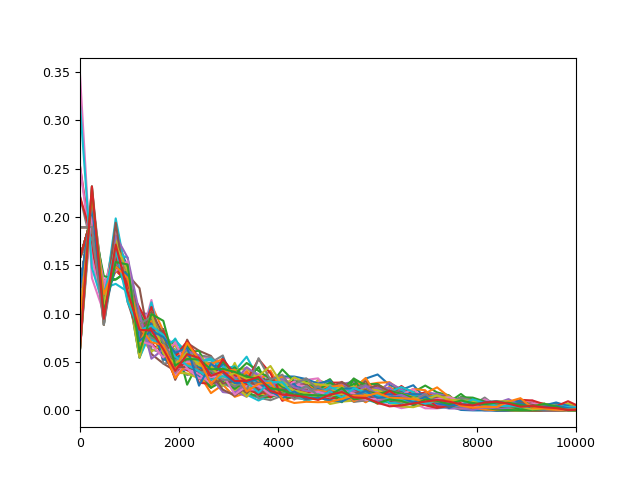

In [77]:
#within sample variance

test =brush_density_function_surface_fixed(data_type6,box, dx=dx,dl=7, bins=200,is_quasi_2D=True)
for te in test:
    #te = np.average(test,axis=0)
    plt.plot(np.array(range(len(te)))*dx*bins,te,label=str(dx))
    plt.xlim([0,10000])
    
plt.show()

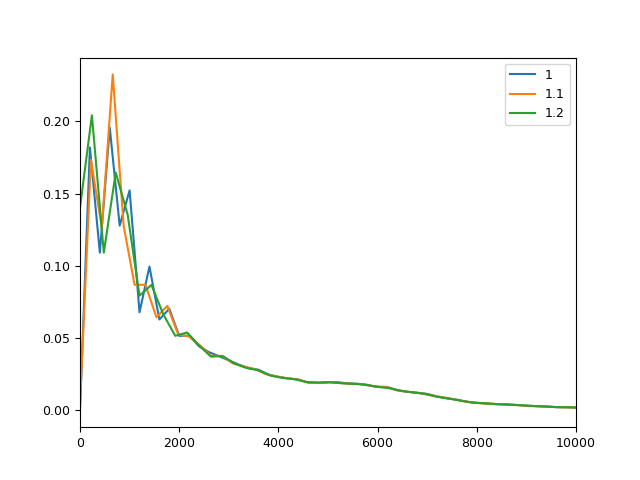

In [78]:
plt.close()
for dx in [1,1.1,1.2]:
    test =brush_density_function_surface_fixed(data_type6,box, dx=dx,dl=7, bins=200,is_quasi_2D=True)
    te = np.average(test,axis=0)
    plt.plot(np.array(range(len(te)))*dx*bins,te,label=str(dx))
    plt.xlim([0,10000])
    plt.legend()
plt.show()

(200,)


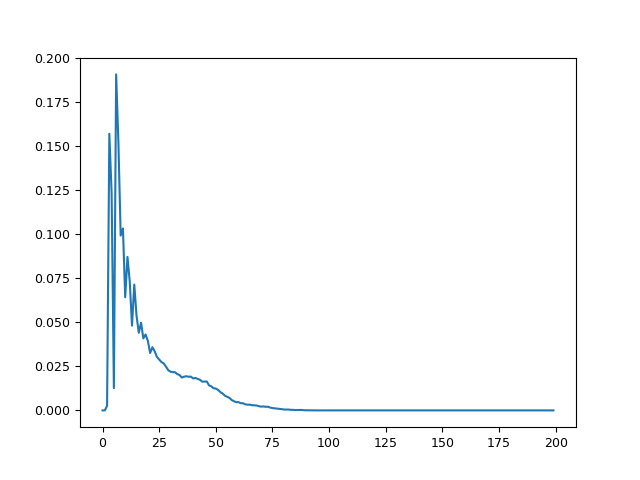

In [47]:
for dx in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
te = np.average(test,axis=0)
print(te.shape)
plt.close()
plt.plot(range(len(te)),te)
plt.show()

# Task 2
run simulations without backbone fluctuations

In [4]:
bins = 200
dx = 1.2
range_end = bins*dx*0.5+ dx*0.5#sigma to nm = 0.5 
range_start = dx*0.5
range_step = dx*0.5
Distance_r = np.arange(range_start, range_end, range_step)
for i in [111,222,333]:
    #file = 'Final_test/ssDNA/{}/product.lammpstrj'.format(i)
    file = '/home/popo/Code file/Condensation_analysis/Charge_Density_analysis/ssDNA/product_{}.lammpstrj'.format(i)
    data_type3, data_type6,box = Process_LAMMPS_Data_Silicification(file)
    brush = brush_density_function_surface_fixed(data_type6,box, dx=dx,dl=7, bins=200,is_quasi_2D=True)

    saved_density = np.average(brush,axis=0)
    
    df = pd.DataFrame({'Y (nm^3)':saved_density, 'X':Distance_r})
    df.to_csv('brush_density_ssDNA_fixed{}.csv'.format(i), index=False)
    #np.save('brush_density_ssDNA{}'.format(i),saved_density)
    
    file = '/home/popo/Code file/Condensation_analysis/Charge_Density_analysis/hairpin/product_{}.lammpstrj'.format(i)
    data_type3, data_type6,box = Process_LAMMPS_Data_Silicification(file)
    brush = brush_density_function_surface_fixed(data_type6,box, dx=dx,dl=7, bins=200,is_quasi_2D=True)
    saved_density = np.average(brush,axis=0)
    df = pd.DataFrame({'Y (nm^3)':saved_density, 'X':Distance_r}) 
    df.to_csv('brush_density_dsDNA_fixed{}.csv'.format(i), index=False)

In [5]:
csv_files = ['brush_density_ssDNA_fixed111.csv', 'brush_density_ssDNA_fixed222.csv', 'brush_density_ssDNA_fixed333.csv',\
            'brush_density_dsDNA_fixed111.csv', 'brush_density_dsDNA_fixed222.csv', 'brush_density_dsDNA_fixed333.csv']

data_frames = []
for index,file_name in enumerate(csv_files):
    df = pd.read_csv(file_name)
    df['Source'] = 'Sample {}'.format(file_name[-5]) #so would be Sample 1 Sample 2
    if file_name[-18:-16]=='ss':
        df['Type'] = '6HB-5*/17/5*'
        charge_perpoint=3.2 #ssDNA = 3.2e
        unit_charge_per_volume = 1/(5.3*8)#unit convert to real unit e/nm^3
        df['Y (nm^3)'] = df['Y (nm^3)'].apply(lambda x: x*charge_perpoint*unit_charge_per_volume) #convert to charge per volume
        
    else:
        df['Type'] = '6HB-5*/17/5*-DS'
        charge_perpoint=11.8 #dsDNA = 11.8e
        unit_charge_per_volume = 1/(5.3*8)#unit convert to real unit e/nm^3
        df['Y (nm^3)'] = df['Y (nm^3)'].apply(lambda x: x*charge_perpoint*unit_charge_per_volume) #convert to charge per volume

    data_frames.append(df)

concatenated_df = pd.concat(data_frames, ignore_index=True)
concatenated_df.head()


,Y (nm^3),X,Source,Type
0,0.028607,0.6,Sample 1,6HB-5*/17/5*
1,0.009905,1.2,Sample 1,6HB-5*/17/5*
2,0.009854,1.8,Sample 1,6HB-5*/17/5*
3,0.008742,2.4,Sample 1,6HB-5*/17/5*
4,0.007209,3.0,Sample 1,6HB-5*/17/5*


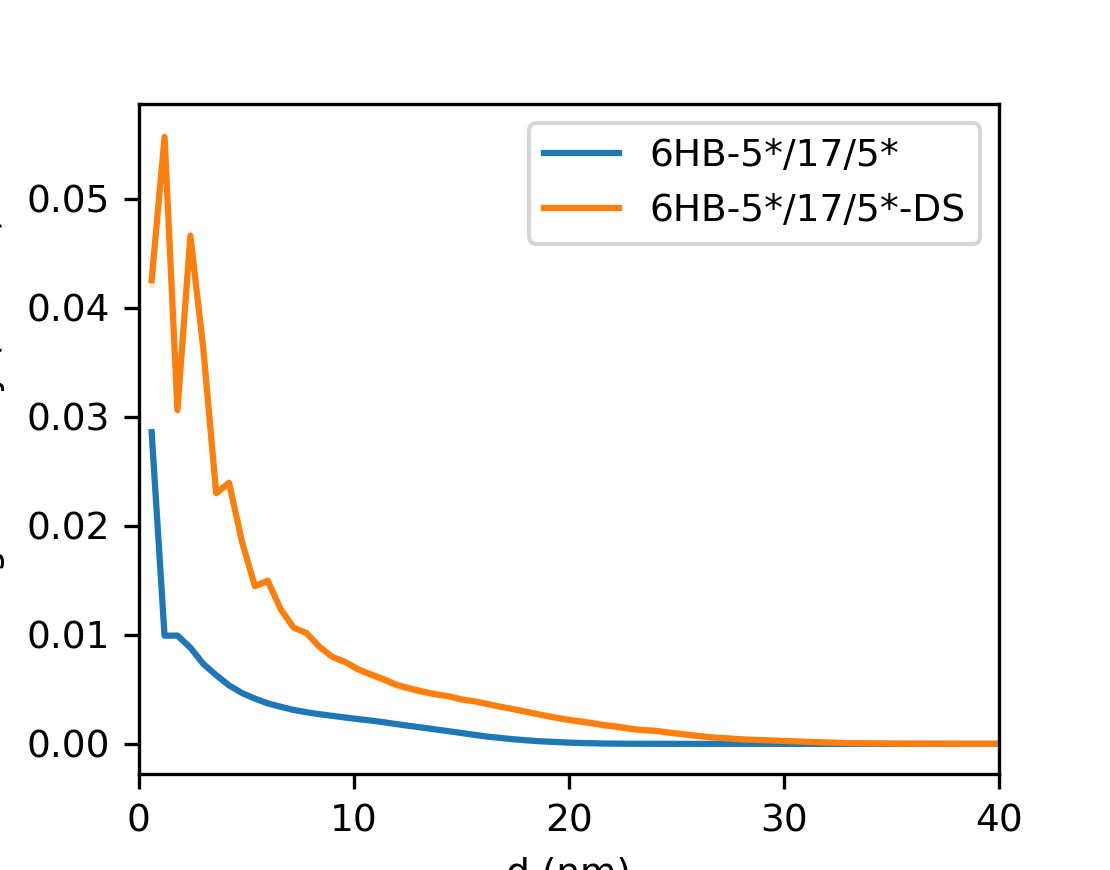

In [7]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib.pyplot import figure
plt.close()
plt.clf()
figure(figsize=(3.7, 2.9), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=concatenated_df, x="X", y="Y (nm^3)",
                 hue="Type",style="Type",errorbar='se',dashes=False)
handles,labels = ax.get_legend_handles_labels()
#handles = [handles[2], handles[3],handles[0], handles[1]]
#labels = ['6HB-5*/17/5*-DS (Brush-grafted)','6HB-5*/17/5*-DS (Bare)','6HB-5*/17/5* (Brush-grafted)','6HB-5*/17/5* (Bare)']#[labels[0], labels[1],labels[2], labels[3]]
plt.legend(handles,labels,title='', loc='upper left')
#ax.set(ylim=(0, 16))
ax.set(xlim=(0, 40))
ax.legend(markerscale=1)
#specfiy axis labels
ax.set(xlabel=r'd (nm)',
           ylabel=r'Charge Density ($e/\mathrm{nm}^3$)',
           title='')
plt.savefig("brush_charge_density.pdf",bbox_inches='tight',dpi=300)
plt.show()



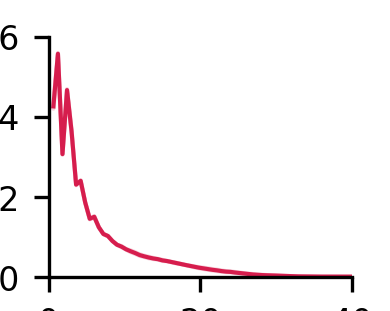

In [28]:
# plot DS and SS individually 
DS_df = concatenated_df.loc[concatenated_df['Type']=='6HB-5*/17/5*-DS']
#determine figure size
fig_w = 94.1565*0.013834867007874
fig_h = 75.1503*0.013834867007874#71.1503*0.013834867007874

plt.close()
plt.clf()
figure(figsize=(fig_w, fig_h), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=DS_df, x="X", y="Y (nm^3)",palette=['#D61D4D'],
                 hue="Type",style="Type",errorbar='se',dashes=False,linewidth=1)
ax.set(xlim=(0, 40))
ax.set(ylim=(0, 0.06))
#ax.legend(markerscale=1)
#specfiy axis labels
ax.get_legend().remove()
ax.set(xlabel=r'r (nm)',
           ylabel='Charge Density' '\n' r'($e/\mathrm{nm}^3$)',
           title='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.axis('off')
plt.savefig('DS_charge_density.pdf', bbox_inches='tight', transparent=True, pad_inches=0,dpi=600)

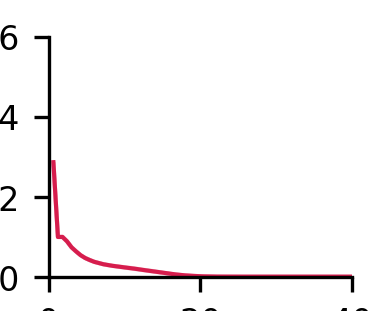

In [29]:
# plot DS and SS individually 
DS_df = concatenated_df.loc[concatenated_df['Type']=='6HB-5*/17/5*']
#determine figure size
fig_w = 94.1565*0.013834867007874
fig_h = 75.1503*0.013834867007874#71.1503*0.013834867007874

plt.close()
plt.clf()
figure(figsize=(fig_w, fig_h), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=DS_df, x="X", y="Y (nm^3)",palette=['#D61D4D'],
                 hue="Type",style="Type",errorbar='se',dashes=False,linewidth=1)
ax.set(xlim=(0, 40))
ax.set(ylim=(0, 0.06))
#ax.legend(markerscale=1)
#specfiy axis labels
ax.get_legend().remove()
ax.set(xlabel=r'r (nm)',
           ylabel='Charge Density' '\n' r'($e/\mathrm{nm}^3$)',
           title='')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.axis('off')
plt.savefig('SS_charge_density.pdf', bbox_inches='tight', transparent=True, pad_inches=0,dpi=600)

# Task
find the corresponding backbone id so that I can calculate
the distance between 6HB surface and the brush

In [3]:
molid_chain_i_need= ([
    (14, 15, 16),
    (209, 210, 211),
    (404, 405, 406),
    (593, 594, 595),
    (788, 789, 790),
    (983, 984, 985),
    (182, 183, 184),
    (371, 372, 373),
    (566, 567, 568),
    (761, 762, 763),
    (950, 951, 952),
    (1145, 1146, 1147)
])
molid_chain_i_need_brush_backbone =np.array(molid_chain_i_need)[:,0]

surface_6HB_bead = sorted([1035,17805,34575,50829,67599,84369,98301,31737,15483,48507,65277,81531])
reference = dict(zip(surface_6HB_bead, sorted(molid_chain_i_need)))


In [4]:
def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = key#[key] 
            else: 
                inverse[item].append(key) 
    return inverse
flipped_reference = invert_dict(reference)
#toy example, given the brush id find the corresponding backbone id
flipped_reference[762]
#flipped_reference_data = {
#    (14, 15, 16): 1035,
#    (182, 183, 184): 15483,
#    (209, 210, 211): 17805,
#    (371, 372, 373): 31737,
#    (404, 405, 406): 34575,
#    (566, 567, 568): 48507,
#    (593, 594, 595): 50829,
#    (761, 762, 763): 62577,
#    (788, 789, 790): 67599,
#    (950, 951, 952): 81531,
#    (983, 984, 985): 84369,
#    (1145, 1146, 1147): 98301
#}



65277

In [7]:
bins = 200
dx = 1.1
range_end = bins*dx*0.5+ dx*0.5#sigma to nm = 0.5 
range_start = dx*0.5
range_step = dx*0.5
Distance_r = np.arange(range_start, range_end, range_step)
for i in [111,222,333]:
    #file = 'Final_test/ssDNA/{}/product.lammpstrj'.format(i)
    file = '/home/popo/Code file/Condensation_analysis/Final_test/Ultra_Final_Final_test/ssDNA/product_{}.lammpstrj'.format(i)
    data_type3, data_type6,box = Process_LAMMPS_Data_Silicification(file)
    brush = brush_density_function_surface_modified(data_type6,data_type3,flipped_reference,box,dx=dx,dl=7, bins=bins,is_quasi_2D=True)

    saved_density = np.average(brush,axis=0)
    
    df = pd.DataFrame({'Y (nm)':saved_density, 'X':Distance_r})
    df.to_csv('brush_density_ssDNA{}.csv'.format(i), index=False)
    #np.save('brush_density_ssDNA{}'.format(i),saved_density)
    
    file = '/home/popo/Code file/Condensation_analysis/Final_test/Ultra_Final_Final_test/hairpin/product_{}.lammpstrj'.format(i)
    data_type3, data_type6,box = Process_LAMMPS_Data_Silicification(file)
    brush = brush_density_function_surface_modified(data_type6,data_type3,flipped_reference,box,dx=dx,dl=7, bins=bins,is_quasi_2D=True)
    saved_density = np.average(brush,axis=0)
    df = pd.DataFrame({'Y (nm)':saved_density, 'X':Distance_r}) #this name doens't make sense
    df.to_csv('brush_density_dsDNA{}.csv'.format(i), index=False)
    #np.save('brush_density_dsDNA{}'.format(i),saved_density)


In [8]:
csv_files = ['brush_density_ssDNA111.csv', 'brush_density_ssDNA222.csv', 'brush_density_ssDNA333.csv',\
            'brush_density_dsDNA111.csv', 'brush_density_dsDNA222.csv', 'brush_density_dsDNA333.csv']

data_frames = []
for index,file_name in enumerate(csv_files):
    df = pd.read_csv(file_name)
    df['Source'] = 'Sample {}'.format(file_name[-5]) #so would be Sample 1 Sample 2
    if file_name[-12:-10]=='ss':
        df['Type'] = '6HB-5*/17/5*'
        charge_perpoint=3.2 #ssDNA = 3.2e
        unit_charge_per_volume = 1/(5.3*8)#unit convert to real unit e/nm^3
        df['Y (nm)'] = df['Y (nm)'].apply(lambda x: x*charge_perpoint*unit_charge_per_volume) #convert to charge per volume
        
    else:
        df['Type'] = '6HB-5*/17/5*-DS'
        charge_perpoint=11.8 #dsDNA = 11.8e
        unit_charge_per_volume = 1/(5.3*8)#unit convert to real unit e/nm^3
        df['Y (nm)'] = df['Y (nm)'].apply(lambda x: x*charge_perpoint*unit_charge_per_volume) #convert to charge per volume

    data_frames.append(df)

concatenated_df = pd.concat(data_frames, ignore_index=True)
concatenated_df.tail()

,Y (nm),X,Source,Type
1195,0.0,107.80,Sample 3,6HB-5*/17/5*-DS
1196,0.0,108.35,Sample 3,6HB-5*/17/5*-DS
1197,0.0,108.90,Sample 3,6HB-5*/17/5*-DS
1198,0.0,109.45,Sample 3,6HB-5*/17/5*-DS
1199,0.0,110.00,Sample 3,6HB-5*/17/5*-DS


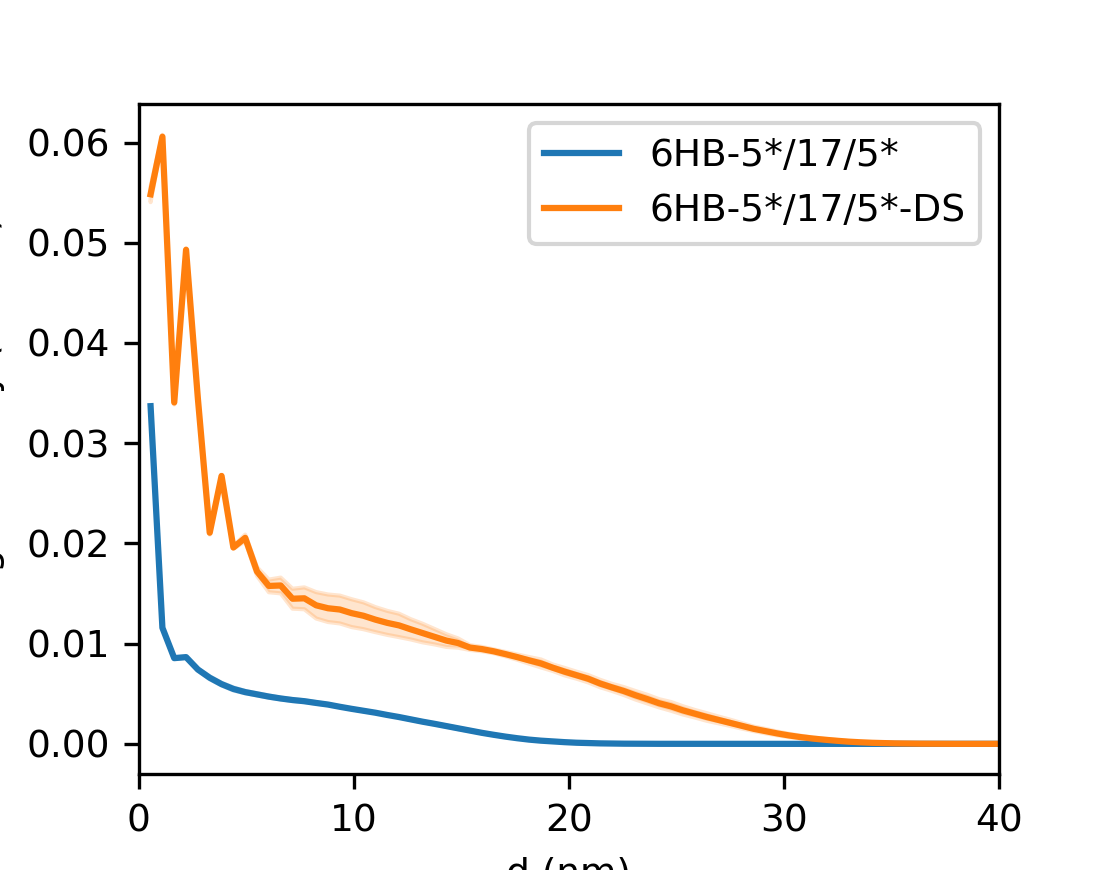

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from matplotlib.pyplot import figure
plt.close()
plt.clf()
figure(figsize=(3.7, 2.9), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=concatenated_df, x="X", y="Y (nm)",
                 hue="Type",style="Type",errorbar='se',dashes=False)
handles,labels = ax.get_legend_handles_labels()
#handles = [handles[2], handles[3],handles[0], handles[1]]
#labels = ['6HB-5*/17/5*-DS (Brush-grafted)','6HB-5*/17/5*-DS (Bare)','6HB-5*/17/5* (Brush-grafted)','6HB-5*/17/5* (Bare)']#[labels[0], labels[1],labels[2], labels[3]]
plt.legend(handles,labels,title='', loc='upper left')
#ax.set(ylim=(0, 16))
ax.set(xlim=(0, 40))
ax.legend(markerscale=1)
#specfiy axis labels
ax.set(xlabel=r'd (nm)',
           ylabel=r'Charge Density ($e/\mathrm{nm}^3$)',
           title='')
plt.savefig("brush_charge_density.pdf",bbox_inches='tight',dpi=300)
#plt.axis('off')
#plt.savefig('out.png', bbox_inches='tight', pad_inches=0)

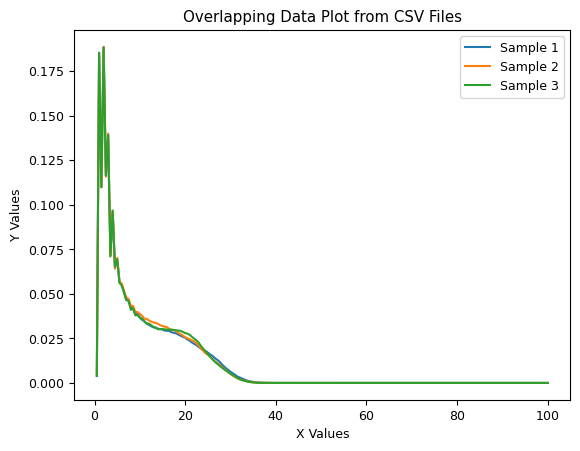

In [231]:
#Variation within sampling
csv_files = ['brush_density_dsDNA111.csv', 'brush_density_dsDNA222.csv', 'brush_density_dsDNA333.csv',\
            ]

data_frames = []
for index,file_name in enumerate(csv_files):
    df = pd.read_csv(file_name)
    data_frames.append(df)
for index, df in enumerate(data_frames):
    plt.plot(df['X'], df['Y (nm)'], label=f"Sample {index + 1}")

# Set labels and title
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Overlapping Data Plot from CSV Files')

# Add legend
plt.legend()

# Show the plot
plt.show()

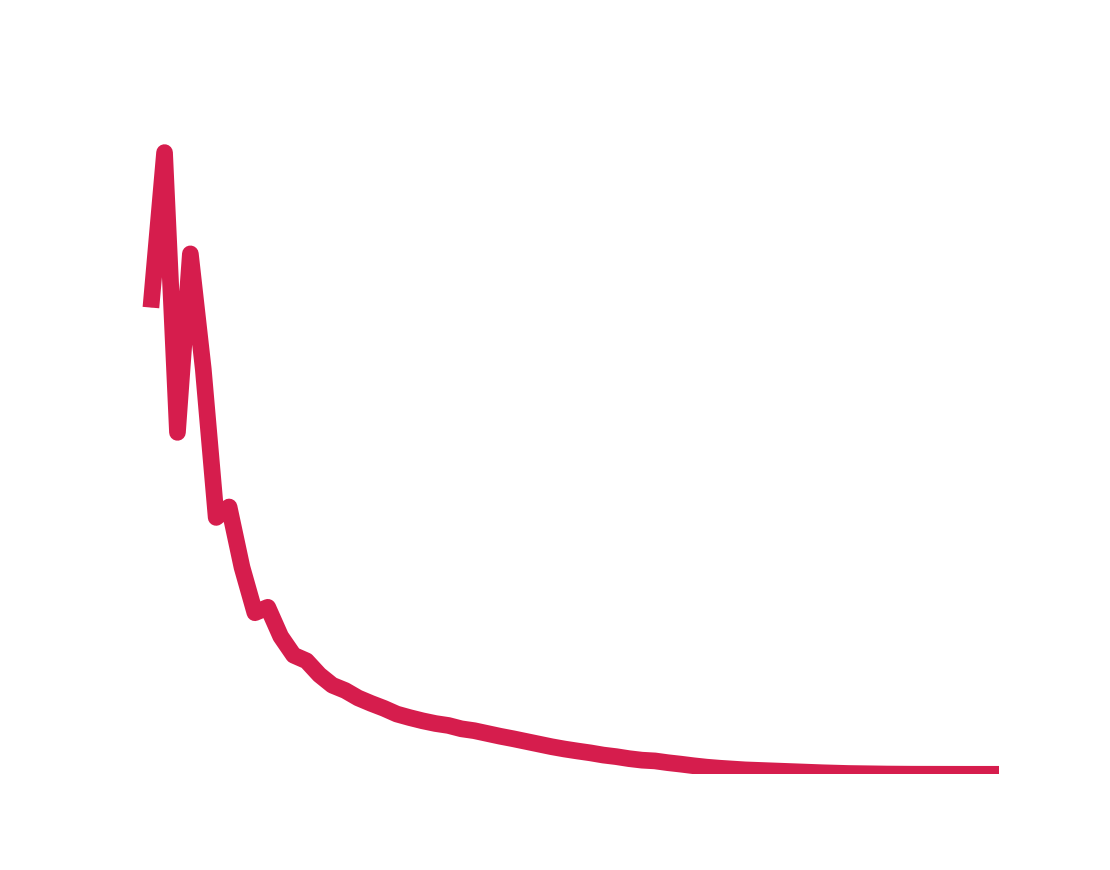

In [9]:
# plot DS and SS individually 
DS_df = concatenated_df.loc[concatenated_df['Type']=='6HB-5*/17/5*-DS']

plt.close()
plt.clf()
figure(figsize=(3.7, 2.9), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 9})
mpl.rcParams['lines.markeredgewidth'] = 1
ax = sns.lineplot(data=DS_df, x="X", y="Y (nm^3)",palette=['#D61D4D'],
                 hue="Type",style="Type",errorbar='se',dashes=False,linewidth=4)
ax.set(xlim=(0, 40))
ax.set(ylim=(0, 0.06))
#ax.legend(markerscale=1)
#specfiy axis labels
ax.get_legend().remove()
ax.set(xlabel=r'd (nm)',
           ylabel=r'Charge Density ($e/\mathrm{nm}^3$)',
           title='')
plt.axis('off')
plt.savefig('DS_charge_density.png', bbox_inches='tight', transparent=True, pad_inches=0)

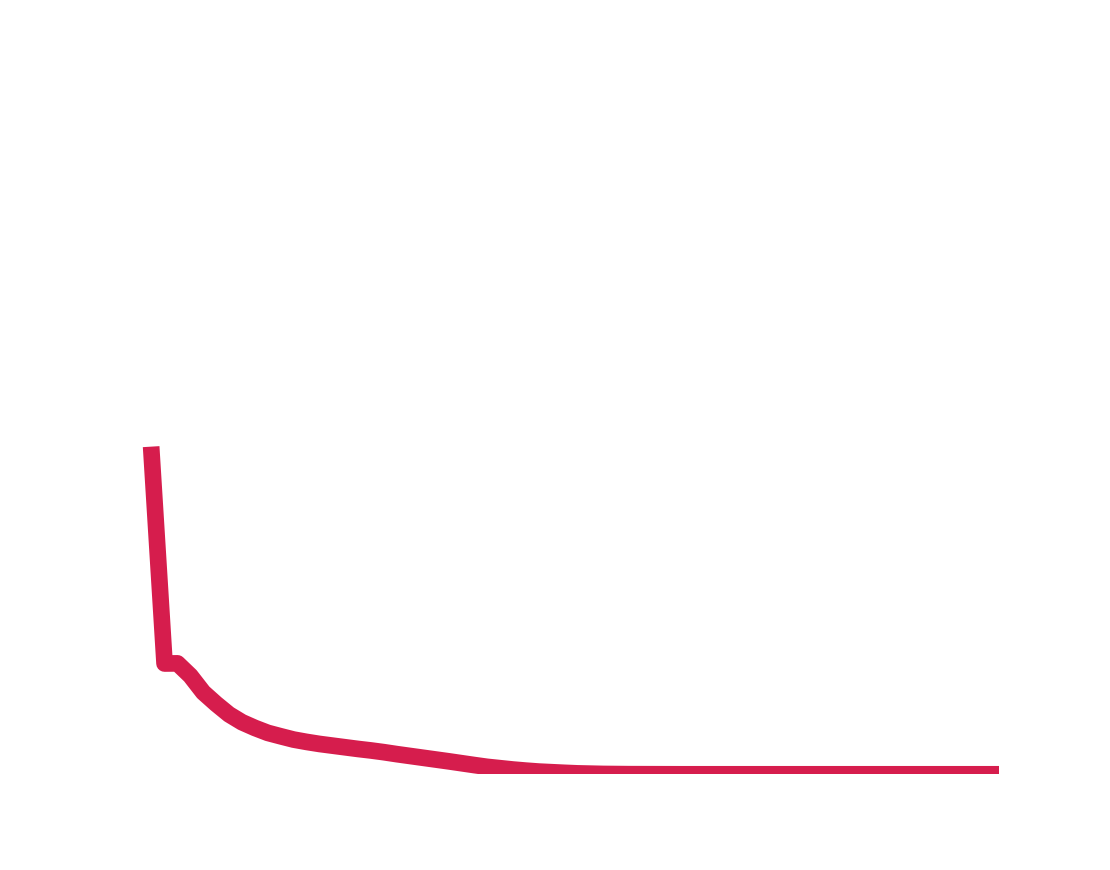

In [10]:
# plot DS and SS individually 
SS_df = concatenated_df.loc[concatenated_df['Type']=='6HB-5*/17/5*']

plt.close()
plt.clf()
figure(figsize=(3.7, 2.9), dpi=300)
mpl.rcParams['pdf.fonttype'] = 42 #To make this editable in Adobe
mpl.rcParams.update({'font.size': 9})
ax = sns.lineplot(data=SS_df, x="X", y="Y (nm^3)",palette=['#D61D4D'],
                 hue="Type",style="Type",errorbar='se',dashes=False,linewidth=4)
ax.set(xlim=(0, 40))
ax.set(ylim=(0, 0.06))
#ax.legend(markerscale=1)
#specfiy axis labels
ax.get_legend().remove()
ax.set(xlabel=r'd (nm)',
           ylabel=r'Charge Density ($e/\mathrm{nm}^3$)',
           title='')
plt.axis('off')
plt.savefig('SS_charge_density.png', bbox_inches='tight', transparent=True, pad_inches=0)